# BEM-BEM Coupling using a simple multitrace formulation

## Background

In this tutorial, we demonstrate the solution of a Helmholtz transmission problem using a simple multitrace formulation.
The basic multitrace operator has the form
$$
\mathsf{A}:=\begin{bmatrix}
-\mathsf{K} & \mathsf{V}\\
\mathsf{W} & \mathsf{K}'\end{bmatrix},
$$
where $\mathsf{K}$, $\mathsf{V}$, $\mathsf{K}'$ and $\mathsf{W}$ are the double layer, single layer, adjoint double layer and hypersingular boundary operators.

This multitrace operator has important properties. If $V = [u,u_\nu]$ is a pair of Dirichlet/Neumann data of an interior Helmholtz solution then
$$
\left[\tfrac{1}{2}\mathsf{Id} + \mathsf{A}\right]V=V.
$$
Similarly, if $V$ is a boundary data pair of an exterior radiating Helmholtz solution then
$$
\left[\tfrac{1}{2}\mathsf{Id} - \mathsf{A}\right]V=V.
$$
Furthermore, from the above properties it follows that $(2\mathsf{A})^2 = \mathsf{Id}$. Hence, this operator is self-regularising. This property is heavily used in <a href='https://bempp_cl.com/2017/07/13/electric-field-integral-equation-efie/'>Calder&oacute;n preconditioning</a>.

Now let $\mathsf{A}^\text{--}$ be the multitrace operator for an interior Helmholtz problem with wavenumber $k^\text{--}$ and $A^\text{+}$ be the multitrace operator for an exterior Helmholtz problem with wavenumber $k^\text{+}$. Let $V^\text{inc}:= [u^\text{inc}, u_\nu^\text{inc}]$ be the boundary data of an incident wave (eg a plane wave). It follows from the properties of the multitrace operator that the solution pair of the Helmholtz scattering problem $V$ satisfies
$$
\left[\tfrac{1}{2}\mathsf{Id} + \mathsf{A}^\text{--}\right]V = \left[\tfrac{1}{2}\mathsf{Id} - \mathsf{A}^\text{+}\right]V + V^\text{inc}
$$
giving
$$
(\mathsf{A}^\text{--} + \mathsf{A}^\text{--})V = V^\text{inc}.
$$
To regularize this equation we multiply with $(\mathsf{A}^\text{--} + \mathsf{A}^\text{+})$ to obtain
$$
(\mathsf{A}^\text{--} + \mathsf{A}^\text{+})^2 = (\mathsf{A}^\text{--} + \mathsf{A}^\text{+})V^\text{inc}.
$$
More details can be found in <a href='http://onlinelibrary.wiley.com/doi/10.1002/cpa.21462/abstract' target='new'>Claeys & Hiptmair (2013)</a>.

The implementation of multitrace operators requires care. If we want to use a typical dual space pairing of piecewise constant functions for the Neumann data and continuous, piecewise linear functions for the Dirichlet data, we need to define the constant functions on the dual grid to ensure that both have the same number of unknowns and a stable dual-space pairing. Bempp implements constant basis functions on dual grids. However, the computational effort grows significantly as a dual grid approach requires barycentrically refined grids that have six times as many elements as the original grid.

The following code automates all these steps. But because of the dual grid approach it requires the assembly of operators on quite large grids even though the original problem is relatively small.

## Implementation

We start with the ususal imports.

In [1]:
import bempp_cl.api
import numpy as np

The following defines the wavenumber and the grid. We use roughly 10 elements per wavelength. The wavenumber in the interior domain is $n * k$, where $n$ is a refractive index.

In [2]:
k = 2
n = 0.5
h = 2 * np.pi / (10 * k)
grid = bempp_cl.api.shapes.ellipsoid(1.5, 1, 1, h=h)

We now define the Dirichlet and Neumann data of the incident wave.

In [3]:
@bempp_cl.api.complex_callable
def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])


@bempp_cl.api.complex_callable
def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k * n[0] * np.exp(1j * k * x[0])

The following code defines the interior and exterior multitrace operators. In particular, the operator product is interesting. Bempp handles all occuring mass matrices automatically. The assembly of a multitrace operator is efficient in the sense that only one single layer and one double layer operator need to be assembled. All others are derived from those two. The ``multitrace_operator`` method uses the correct spaces for the Dirichlet and Neumann data. To access these spaces we just access the spaces of the component operators.

In [4]:
Ai = bempp_cl.api.operators.boundary.helmholtz.multitrace_operator(grid, n * k)
Ae = bempp_cl.api.operators.boundary.helmholtz.multitrace_operator(grid, k)

op = Ai + Ae
op_squared = op * op

dirichlet_space = Ai[0, 0].domain
neumann_space = Ai[0, 1].domain

We need to discretise the incident field into grid functions.

In [5]:
dirichlet_grid_fun = bempp_cl.api.GridFunction(dirichlet_space, fun=dirichlet_fun)
neumann_grid_fun = bempp_cl.api.GridFunction(neumann_space, fun=neumann_fun)

The following discretises the left-hand side operator and the right-hand side vector.

In [6]:
op_discrete = op.strong_form()
op_discrete_squared = op_discrete * op_discrete
rhs = op_discrete * np.concatenate([dirichlet_grid_fun.coefficients, neumann_grid_fun.coefficients])

/dolfinx-env/lib/python3.12/site-packages/bempp_cl/api/assembly/discrete_boundary_operator.py:619: SparseEfficiencyWarning: splu converted its input to CSC format
  solver = solver_interface(actual_mat)


We can now solve the discretised linear system and recover the Dirichlet and Neumann boundary data of the solution.

In [7]:
from scipy.sparse.linalg import gmres

it_count = 0


def iteration_counter(x):
    global it_count
    it_count += 1


x, info = gmres(op_discrete_squared, rhs, callback=iteration_counter)
print("The linear system was solved in {0} iterations".format(it_count))

total_field_dirichlet = bempp_cl.api.GridFunction(dirichlet_space, coefficients=x[: dirichlet_space.global_dof_count])
total_field_neumann = bempp_cl.api.GridFunction(neumann_space, coefficients=x[dirichlet_space.global_dof_count :])

The linear system was solved in 6 iterations


We now generate the points for the plot of a slice of the solution in the $z=0$ plane.

In [8]:
Nx = 300
Ny = 300
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size)))
u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)

x, y = points[:2]
idx_ext = np.sqrt((x / 1.5) ** 2 + y**2) > 1.0
idx_int = np.sqrt((x / 1.5) ** 2 + y**2) <= 1.0

points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

To compute the solution in the interior and exterior of the sphere we need to assemble the corresponding potential operators and then compute the field data using Greens' representation formula.

In [9]:
slp_pot_int = bempp_cl.api.operators.potential.helmholtz.single_layer(dirichlet_space, points_interior, n * k)
slp_pot_ext = bempp_cl.api.operators.potential.helmholtz.single_layer(dirichlet_space, points_exterior, k)
dlp_pot_int = bempp_cl.api.operators.potential.helmholtz.double_layer(dirichlet_space, points_interior, n * k)
dlp_pot_ext = bempp_cl.api.operators.potential.helmholtz.double_layer(dirichlet_space, points_exterior, k)

total_field_int = (slp_pot_int * total_field_neumann - dlp_pot_int * total_field_dirichlet).ravel()
total_field_ext = (dlp_pot_ext * total_field_dirichlet - slp_pot_ext * total_field_neumann).ravel() + np.exp(
    1j * k * points_exterior[0]
)

total_field = np.zeros(points.shape[1], dtype="complex128")
total_field[idx_ext] = total_field_ext
total_field[idx_int] = total_field_int
total_field = total_field.reshape([Nx, Ny])

Finally, we can plot the solution of the scattering problem in the $z=0$ plane.

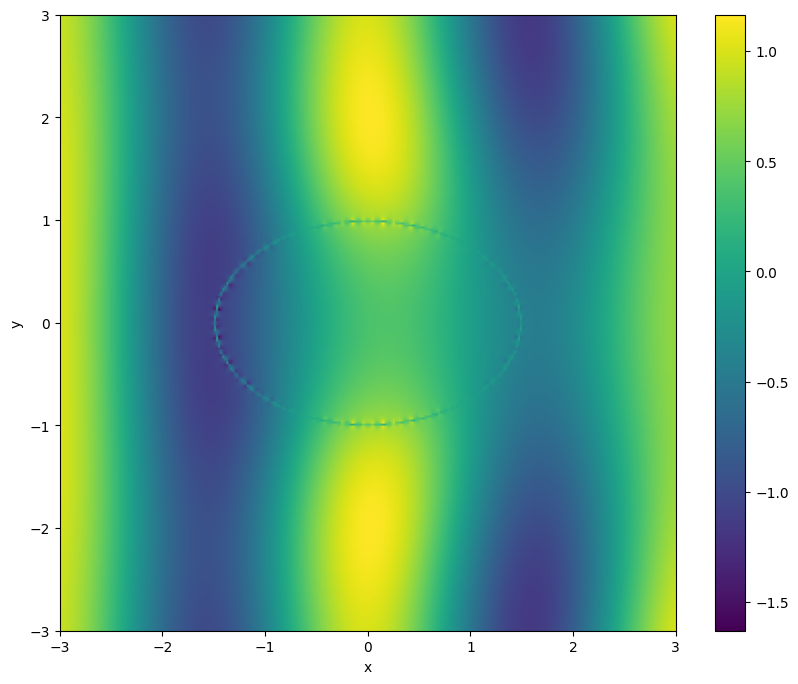

In [10]:
try:
    get_ipython().run_line_magic("matplotlib", "inline")
    ipython = True
except NameError:
    ipython = False
from matplotlib import pylab as plt

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(total_field.T), extent=[-3, 3, -3, 3])
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
if not ipython:
    plt.savefig("example-bem_bem_multitrace_coupling.png")